This is notebook is to test and inspect how the model works on data that has not been used in the training process (108 images).

In [3]:
import copy
import os
from math import ceil
import pickle

import optuna
from optuna.trial import TrialState
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [4]:
MAX_SIZE = 640

In [5]:
def calcNewDimsWH(width, height, maxSize):
    """ calc dims for downscale image according to maximum allowed size """
    
    if width < height:
        newHeight = maxSize
        ratio = height/maxSize
        newWidth = ceil(width/ratio)
    else:
        newWidth = maxSize
        ratio = width/maxSize
        newHeight = ceil(height/ratio)
        
    return newWidth, newHeight



def convertLabelCsvSize(old_csv, new_csv, width, height, equal_size):
    """ Correct bounding box data in csv for downsampled images """

    df = pd.read_csv(old_csv, names=['target', 'c1', 'c2', 'c3', 'c4', 'imageFile', 'w', 'h'])
    
    if equal_size:
        new_width = width
        new_height = height
        
    else:
        new_width = []
        new_height = []
        
        for w, h in zip(df.w, df.h):
            new_w, new_h = calcNewDimsWH(w, h, MAX_SIZE)
            new_width.append(new_w)
            new_height.append(new_h)
            
        new_width = np.array(new_width)
        new_height = np.array(new_height)
    
    c1 = np.round(df.c1/df.w * new_width).astype('int')
    c2 = np.round(df.c2/df.h * new_height).astype('int')
    c3 = np.round(df.c3/df.w * new_width).astype('int')
    c4 = np.round(df.c4/df.h * new_height).astype('int')
    df2 = pd.DataFrame({'target':df.target, 'c1':c1, 'c2':c2, 'c3':c3, 'c4':c4, 'imageFile':df.imageFile, 'w':new_width, 'h':new_height}, columns=None)
        
    df2.to_csv(new_csv, header=False, index=False)
    
    


In [6]:
imageFolder = 'roi_test_set_max640'
#old_csv = 'roi_test_set/labels_my-project-name_2022-03-01-07-11-23.csv'
new_csv = 'roi_test_set_max640/labels_2022-03-01.csv'
#convertLabelCsvSize(old_csv, new_csv, MAX_SIZE, MAX_SIZE, False)
labeledCSV = new_csv

In [175]:
def get_model_simple():
    
    """ Returns FasterRCNN with Mobilenet v3 backbone (resizing images to 320px on the shorter side) prepared for transfer learning """
    
    model = models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True, box_detections_per_img=1, box_score_thresh=0.02)
    for param in model.parameters():
        param.requires_grad = False

    num_classes = 3  # painting, object & background
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    
    return model


device = torch.device('cpu')

# loading two models
model = get_model_simple()
model_eval = get_model_simple()
model.load_state_dict(torch.load('mobilenet_320_all_15_07_23_gc.pkl', map_location=device))
model_eval.load_state_dict(torch.load('mobilenet_320_all_15_07_23_gc.pkl', map_location=device))
model.train()
model_eval.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): 

In [177]:
RPNtransform = transforms.Compose([ #transforms.Resize((640,640)),
                                    transforms.ToTensor()
                                    ])


class RPNDataset(torch.utils.data.Dataset):
    def __init__(self, imageFolder, labelsPath, subset=None, transform=None):
        
        self.transform = transform
        
        self.df = pd.read_csv(labelsPath, names=['target', 'c1', 'c2', 'c3', 'c4', 'imageFile', 'w', 'h'])
        #print(self.df.head())
        self.labels = self.df.target
        self.x1 = (self.df.c1/self.df.w).to_numpy()
        self.y1 = (self.df.c2/self.df.h).to_numpy()
        self.x2 = ((self.df.c1 + self.df.c3)/self.df.w).to_numpy()
        self.y2 = ((self.df.c2 + self.df.c4)/self.df.h).to_numpy()
        self.images = [os.path.join(imageFolder, image) for image in self.df.imageFile]
        if type(self.df.target[0])==str:
            self.targets = [0 for i in range(len(self.df))]
            for idx, target in enumerate(self.df.target):
                if target == 'image':
                    self.targets[idx] = 1
                elif target == 'object':
                    self.targets[idx] = 0
                else:
                    print( f'error in {target} {idx}')
            self.labels = self.targets
            
        if subset is not None:
            self.x1 = self.x1[subset]
            self.y1 = self.y1[subset]
            self.x2 = self.x2[subset]
            self.y2 = self.y2[subset]
            self.labels = [self.labels[idx] for idx in subset]
            self.images = [self.images[idx] for idx in subset]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = Image.open(self.images[index])
        w = img.width 
        h = img.height 
        
        box = torch.tensor([self.x1[index]*w, self.y1[index]*h, self.x2[index]*w, self.y2[index]*h], dtype=torch.float32)
        target = {
                'boxes': box,
                'labels': torch.tensor(self.labels[index]),
                'image_id' : torch.tensor(index),
                'image_path': self.images[index]
            }
        
        if not img.mode == 'RGB':
            img = img.convert('RGB')

        img = RPNtransform(img)
        return img, target

In [178]:
test_data = RPNDataset(imageFolder, labeledCSV)
batch_size = 1

def collate_fn(batch):
    return tuple(zip(*batch))

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [199]:
all_images = []
true_boxes = []
pred_boxes = []
loss_dicts = []
all_preds = []
all_targets = []

test_loss = []
nr_pred = []


with torch.set_grad_enabled(False):

    for img, targets in test_loader:
        
        all_images.append(targets[0]['image_path'])
        
        targets = [{k: v for k, v in t.items()} for t in targets]
        
        all_targets.append(targets)
        
        true_boxes.append(targets[0]['boxes'].unsqueeze(0).detach().numpy()[0])

        for target in targets:
            target['boxes'] = target['boxes'].unsqueeze(0)
            target['labels'] = target['labels'].unsqueeze(0)
            target['image_id'] = target['image_id'].unsqueeze(0)

        loss_dict = model(img, targets)
        pred = model_eval(img)
        
        
        bbox = pred[0]['boxes'].numpy()
        loss_dicts.append(loss_dict)
        all_preds.append(pred)
        print('targets: ', targets)
        print('loss dict: ', loss_dict)
        print('pred: ', pred, '\n')
        #print('bbox: ', bbox, bbox.shape)
        #print('image: ', targets[0]['image_path'])
        nr_pred.append(bbox.shape)
        
        if bbox.shape[0] > 0:
            pred_boxes.append(bbox)
            
        else:
            # if no painting or object is found, the default prediction is [0.25, 0.25, 0.75, 0.75]
            # not needed for testing
            #bbox_default = np.array([0.25, 0.25, 0.75, 0.75]) * [image_width, image_height, image_width, image_height]
            pred_boxes.append([])

        loss = sum(loss for loss in loss_dict.values())
        loss_value = loss.item()
        #print('loss: ', loss_value, '\n')

        test_loss.append(loss_value)


batch_loss = sum(test_loss)/len(test_loss)

print('Test Batch Loss: {:.4f},  per Instance: {:.4f} '.format(batch_loss, batch_loss/batch_size))


targets:  [{'boxes': tensor([[ 43., 267., 433., 429.]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'image_path': 'roi_test_set_max640/20220203_181852.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0479), 'loss_box_reg': tensor(0.0708), 'loss_objectness': tensor(0.0590), 'loss_rpn_box_reg': tensor(0.0048)}
pred:  [{'boxes': tensor([[ 42.6471, 244.2095, 425.4256, 418.5720]]), 'labels': tensor([1]), 'scores': tensor([0.9327])}] 

targets:  [{'boxes': tensor([[  0., 203., 475., 471.]]), 'labels': tensor([1]), 'image_id': tensor([1]), 'image_path': 'roi_test_set_max640/20220203_181857.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0476), 'loss_box_reg': tensor(0.0620), 'loss_objectness': tensor(0.0258), 'loss_rpn_box_reg': tensor(0.0017)}
pred:  [{'boxes': tensor([[  0.0000, 208.1206, 480.0000, 470.2724]]), 'labels': tensor([1]), 'scores': tensor([0.5734])}] 

targets:  [{'boxes': tensor([[  0., 211., 478., 434.]]), 'labels': tensor([1]), 'image_id': tensor([2]), 'image_path': 'roi_

targets:  [{'boxes': tensor([[149., 161., 350., 542.]]), 'labels': tensor([0]), 'image_id': tensor([19]), 'image_path': 'roi_test_set_max640/20220203_185207.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0185), 'loss_box_reg': tensor(0.), 'loss_objectness': tensor(0.0461), 'loss_rpn_box_reg': tensor(0.0156)}
pred:  [{'boxes': tensor([[2.2878e-01, 9.0279e+01, 4.6026e+02, 4.8040e+02]]), 'labels': tensor([1]), 'scores': tensor([0.2755])}] 

targets:  [{'boxes': tensor([[ 70., 119., 285., 550.]]), 'labels': tensor([0]), 'image_id': tensor([20]), 'image_path': 'roi_test_set_max640/20220203_185209.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0576), 'loss_box_reg': tensor(0.), 'loss_objectness': tensor(0.0368), 'loss_rpn_box_reg': tensor(0.0088)}
pred:  [{'boxes': tensor([[  1.5536,  95.1637, 350.7323, 546.0909]]), 'labels': tensor([1]), 'scores': tensor([0.4720])}] 

targets:  [{'boxes': tensor([[140., 209., 351., 512.]]), 'labels': tensor([0]), 'image_id': tensor([21]), 'image_path': 'r

targets:  [{'boxes': tensor([[ 53., 229., 405., 521.]]), 'labels': tensor([0]), 'image_id': tensor([38]), 'image_path': 'roi_test_set_max640/20220203_191642.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0025), 'loss_box_reg': tensor(0.), 'loss_objectness': tensor(0.1430), 'loss_rpn_box_reg': tensor(0.0018)}
pred:  [{'boxes': tensor([[  0.0000, 193.6145, 447.6404, 544.5628]]), 'labels': tensor([1]), 'scores': tensor([0.0579])}] 

targets:  [{'boxes': tensor([[158., 144., 276., 530.]]), 'labels': tensor([0]), 'image_id': tensor([39]), 'image_path': 'roi_test_set_max640/20220203_192015.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0088), 'loss_box_reg': tensor(0.), 'loss_objectness': tensor(0.0384), 'loss_rpn_box_reg': tensor(0.0048)}
pred:  [{'boxes': tensor([[ 42.1425,   0.0000, 476.9039, 640.0000]]), 'labels': tensor([1]), 'scores': tensor([0.1325])}] 

targets:  [{'boxes': tensor([[172., 156., 302., 552.]]), 'labels': tensor([0]), 'image_id': tensor([40]), 'image_path': 'roi_test_

targets:  [{'boxes': tensor([[150., 146., 297., 542.]]), 'labels': tensor([0]), 'image_id': tensor([57]), 'image_path': 'roi_test_set_max640/20220203_193547.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0284), 'loss_box_reg': tensor(0.), 'loss_objectness': tensor(0.0143), 'loss_rpn_box_reg': tensor(0.0048)}
pred:  [{'boxes': tensor([[133.1915, 126.7648, 308.4021, 506.6711]]), 'labels': tensor([1]), 'scores': tensor([0.5126])}] 

targets:  [{'boxes': tensor([[ 58., 111., 427., 493.]]), 'labels': tensor([0]), 'image_id': tensor([58]), 'image_path': 'roi_test_set_max640/20220203_193709.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0052), 'loss_box_reg': tensor(0.), 'loss_objectness': tensor(0.0735), 'loss_rpn_box_reg': tensor(0.0013)}
pred:  [{'boxes': tensor([[ 80.7388, 128.6331, 427.8302, 447.6714]]), 'labels': tensor([1]), 'scores': tensor([0.1267])}] 

targets:  [{'boxes': tensor([[ 83., 150., 382., 470.]]), 'labels': tensor([0]), 'image_id': tensor([59]), 'image_path': 'roi_test_

targets:  [{'boxes': tensor([[160., 189., 350., 456.]]), 'labels': tensor([1]), 'image_id': tensor([76]), 'image_path': 'roi_test_set_max640/20220206_163458.jpg'}]
loss dict:  {'loss_classifier': tensor(0.1574), 'loss_box_reg': tensor(0.2955), 'loss_objectness': tensor(0.0018), 'loss_rpn_box_reg': tensor(0.0007)}
pred:  [{'boxes': tensor([[152.9886, 168.5008, 337.1757, 450.1266]]), 'labels': tensor([1]), 'scores': tensor([0.9931])}] 

targets:  [{'boxes': tensor([[177., 161., 394., 465.]]), 'labels': tensor([1]), 'image_id': tensor([77]), 'image_path': 'roi_test_set_max640/20220206_163500.jpg'}]
loss dict:  {'loss_classifier': tensor(0.1960), 'loss_box_reg': tensor(0.2518), 'loss_objectness': tensor(0.0013), 'loss_rpn_box_reg': tensor(0.0007)}
pred:  [{'boxes': tensor([[185.6981, 161.2885, 387.6185, 460.3345]]), 'labels': tensor([1]), 'scores': tensor([0.9946])}] 

targets:  [{'boxes': tensor([[ 94., 156., 351., 408.]]), 'labels': tensor([1]), 'image_id': tensor([78]), 'image_path': 'r

targets:  [{'boxes': tensor([[ 94., 206., 363., 396.]]), 'labels': tensor([1]), 'image_id': tensor([95]), 'image_path': 'roi_test_set_max640/20220206_164138.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0458), 'loss_box_reg': tensor(0.0856), 'loss_objectness': tensor(0.0416), 'loss_rpn_box_reg': tensor(0.0004)}
pred:  [{'boxes': tensor([[ 89.9007, 205.2867, 371.5291, 412.6400]]), 'labels': tensor([1]), 'scores': tensor([0.8762])}] 

targets:  [{'boxes': tensor([[ 77., 189., 400., 456.]]), 'labels': tensor([1]), 'image_id': tensor([96]), 'image_path': 'roi_test_set_max640/20220206_164336.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0323), 'loss_box_reg': tensor(0.0259), 'loss_objectness': tensor(0.0252), 'loss_rpn_box_reg': tensor(0.0090)}
pred:  [{'boxes': tensor([[ 86.2745, 157.6125, 404.1709, 462.9612]]), 'labels': tensor([1]), 'scores': tensor([0.9756])}] 

targets:  [{'boxes': tensor([[ 42., 156., 408., 473.]]), 'labels': tensor([1]), 'image_id': tensor([97]), 'image_path': 'r

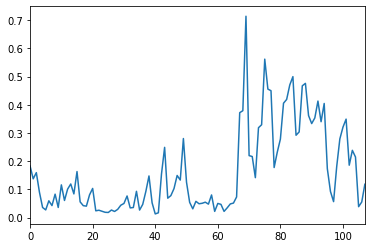

In [204]:
pd.Series(np.array(test_loss)).plot()

In [205]:
np.array(test_loss).argmin()

40

In [202]:
all_images[69]

'roi_test_set_max640/20220203_194611.jpg'

In [12]:
assert len(test_loss) == len(all_images) == len(pred_boxes), 'unequal length'

In [191]:
# converting lists to numpy for argsort

test_loss_n = np.array(test_loss)
all_images = np.array(all_images)
pred_boxes_a = np.array(pred_boxes, dtype=object)
true_boxes = np.array(true_boxes)
loss_dicts = np.array(loss_dicts)
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

In [190]:
test_loss_n.argmax()

69

## Inspecting the test cases with the highest and lowest loss

In [192]:
idxs = (-test_loss_n).argsort()
test_loss_all = test_loss_n[idxs]
top_loss_images = all_images[idxs]
top_loss_boxes_pred = pred_boxes_a[idxs]
top_loss_boxes_true = true_boxes[idxs]
top_loss_preds = all_preds[idxs]
top_loss_dicts = loss_dicts[idxs]
top_loss_targets = all_targets[idxs]

### Highest loss

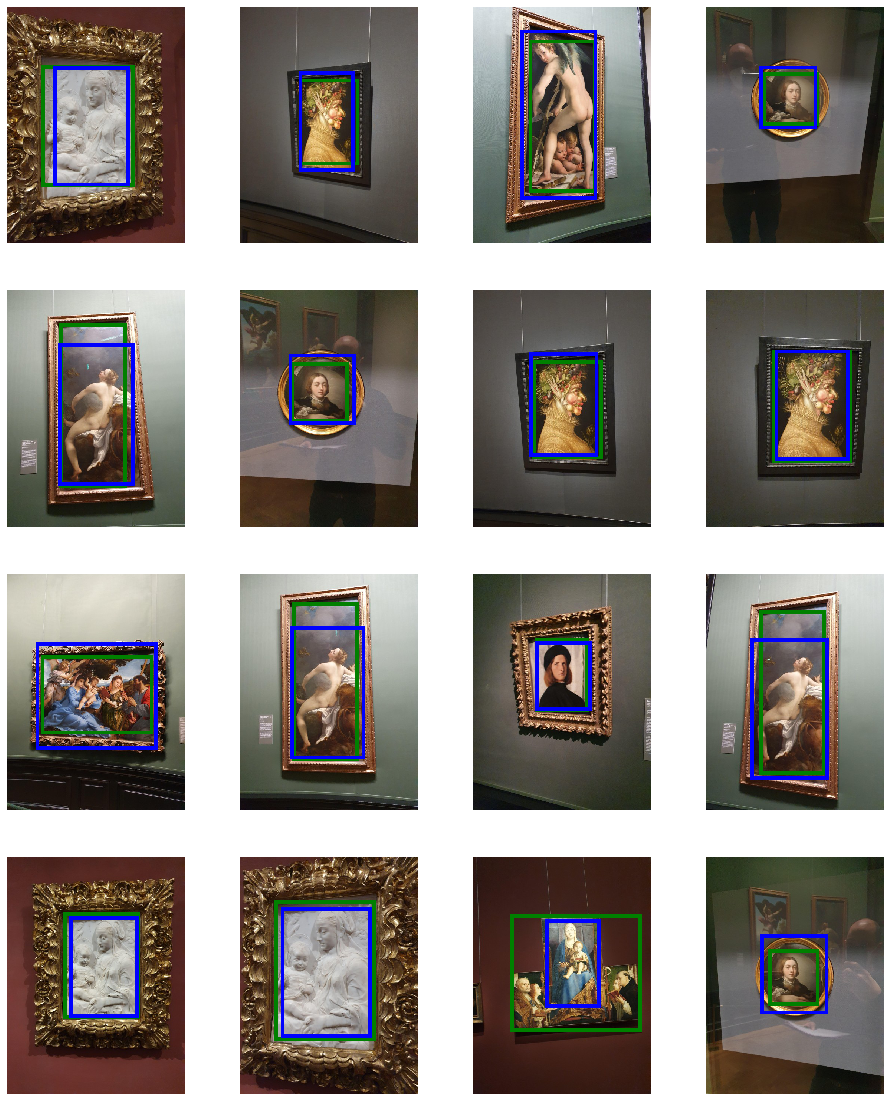

In [211]:

fig = plt.figure(figsize=(16, 140))
columns = 4
rows = 27

for counter, i in enumerate(top_loss_images[:16]):
    img = Image.open(i)
    
    img_true = ImageDraw.Draw(img)
    img_true.rectangle(top_loss_boxes_true[counter].tolist(), outline='green', width=10)
        
    if top_loss_preds[counter][0]['boxes'].shape[0]>0:
        img_pred = ImageDraw.Draw(img)
        img_pred.rectangle(top_loss_preds[counter][0]['boxes'][0].tolist(), outline='blue', width=10)
    
    ax = fig.add_subplot(rows, columns, counter+1)
    
    ax.set_axis_off()
    
    plt.imshow(img, aspect='equal')
    

plt.show()

### Cases with the lowest loss

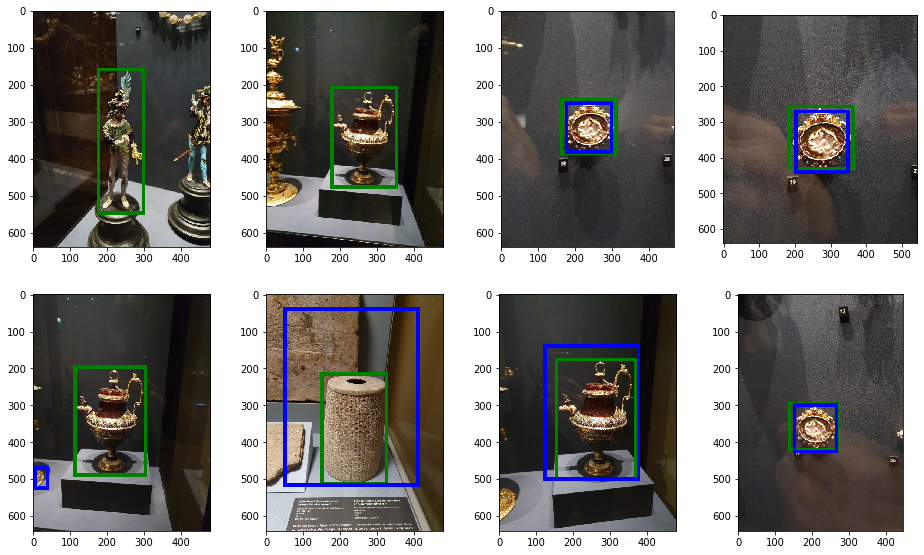

In [197]:
fig = plt.figure(figsize=(16, 140))
columns = 4
rows = 27

counter = 0

for i in range(len(top_loss_images)-1, len(top_loss_images)-8-1, -1):
        
    img_path = top_loss_images[i]
    
    img = Image.open(img_path)
    
    img_true = ImageDraw.Draw(img)
    img_true.rectangle(top_loss_boxes_true[i].tolist(), outline='green', width=10)
        
    if top_loss_preds[i][0]['boxes'].shape[0]>0:
        img_pred = ImageDraw.Draw(img)
        img_pred.rectangle(top_loss_preds[i][0]['boxes'][0].tolist(), outline='blue', width=10)
    
    fig.add_subplot(rows, columns, counter+1)
    plt.imshow(img, aspect='equal')
    
    counter += 1
plt.axis('off')
plt.show()

In [147]:
def inspect_test_case(select):
    
    """ Helper function to print all data and show predicted vs true bounding box """
    
    print('image: ', top_loss_images[select])
    print('pred: ', top_loss_preds[select])
    print('target: ', top_loss_targets[select])
    print('loss dict: ', top_loss_dicts[select], test_loss_all[select])
    print('top loss boxes: ', top_loss_boxes_pred[select], top_loss_boxes_true[select])
    img = Image.open(top_loss_images[select])
    if top_loss_preds[select][0]['boxes'].shape[0]>0:
        img_pred = ImageDraw.Draw(img)
        img_pred.rectangle(top_loss_preds[select][0]['boxes'][0].tolist(), outline='blue', width=10)
    img_true = ImageDraw.Draw(img)
    img_true.rectangle(top_loss_targets[select][0]['boxes'][0].tolist(), outline='green', width=10)
    plt.imshow(img)

image:  roi_test_set_max640/20220206_163456.jpg
pred:  [{'boxes': tensor([[158.4996, 176.4504, 309.7384, 446.8235]]), 'labels': tensor([1]), 'scores': tensor([0.9798])}]
target:  [{'boxes': tensor([[158., 196., 321., 429.]]), 'labels': tensor([1]), 'image_id': tensor([75]), 'image_path': 'roi_test_set_max640/20220206_163456.jpg'}]
loss dict:  {'loss_classifier': tensor(0.1494), 'loss_box_reg': tensor(0.4087), 'loss_objectness': tensor(0.0030), 'loss_rpn_box_reg': tensor(0.0018)} 0.5627783536911011
top loss boxes:  [[158.49962 176.45038 309.7384  446.8235 ]] [158. 196. 321. 429.]


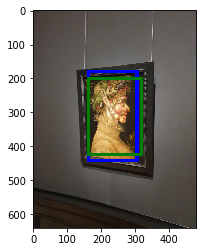

In [196]:
inspect_test_case(1)

image:  roi_test_set_max640/20220203_190308.jpg
pred:  [{'boxes': tensor([[  1.2032, 464.3424,  43.3815, 528.9625]]), 'labels': tensor([1]), 'scores': tensor([0.0776])}]
target:  [{'boxes': tensor([[108., 193., 307., 493.]]), 'labels': tensor([0]), 'image_id': tensor([23]), 'image_path': 'roi_test_set_max640/20220203_190308.jpg'}]
loss dict:  {'loss_classifier': tensor(0.0075), 'loss_box_reg': tensor(0.), 'loss_objectness': tensor(0.0056), 'loss_rpn_box_reg': tensor(0.0032)} 0.016352826729416847
top loss boxes:  [[  1.2031918 464.34238    43.381477  528.96246  ]] [108. 193. 307. 493.]


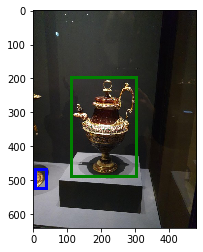

In [194]:
inspect_test_case(-5)